# Wild Animals Detection using YOLOv8

This notebook demonstrates how to implement a wild animals detection system using YOLOv8, Roboflow, and various supporting libraries. The system can detect and track wild animals in both images and videos.

## Table of Contents
1. [Setup and Installation](#setup-and-installation)
2. [Dataset Preparation](#dataset-preparation)
3. [Model Training](#model-training)
4. [Image Detection](#image-detection)
5. [Video Detection](#video-detection)

## 1. Setup and Installation

First, we'll install the required packages:

In [ ]:
%pip install roboflow ultralytics supervision

Import necessary libraries:

In [29]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
from ultralytics import YOLO
from roboflow import Roboflow
import supervision as sv
import requests
import numpy as np
import sys

## 2. Dataset Preparation

### 2.1 Download Dataset from Roboflow
Connect to Roboflow and download the wild animals detection dataset:

In [ ]:
# Initialize Roboflow and download dataset
# Replace YOUR_API_KEY with your actual Roboflow API key
rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("puspendu-ai-vision-workspace").project("wild-animals-detection-fspct")
version = project.version(1)
dataset = version.download("yolov8")

### 2.2 Check Dataset Structure
Install and use the tree command to visualize the dataset structure:


In [ ]:
!apt-get install tree
!tree -L 2 "WILD-ANIMALS-DETECTION-1"

> **Important Note**: Make sure to update the absolute path in the `data.yaml` file before proceeding with training.

## 3. Model Training

Train the YOLOv8 model on our dataset:

In [ ]:
# Initialize and train the model
model = YOLO('yolov8l.pt')  # Load YOLOv8 large model

# Train for 100 epochs with image size 640x640
model.train(
    data="WILD-ANIMALS-DETECTION-1/data.yaml",
    epochs=100,
    imgsz=640
)

## 4. Image Detection

Here's our comprehensive function for detecting animals in images:

In [85]:
def display_prediction(image_path, save_fig=False, filename=None):
    """
    Function to display predictions of a pre-trained YOLO model on a given image.
    
    Parameters:
        image_path (str): Path to the image file. Can be a local path or a URL.
        save_fig (bool): If True, saves the predicted image with annotations. Default is False.
        filename (str): Name of the file to save the image. Required if save_fig is True.
    """

    # Load YOLO model
    model = YOLO("runs/detect/train/weights/best.pt")
    class_dict = model.names

    # Load image from local path or URL
    if image_path.startswith(('http', 'https')):
        try:
            response = requests.get(image_path)
            image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
            img = cv.imdecode(image_array, cv.IMREAD_COLOR)
        except Exception as e:
            print(f"Error loading image from URL: {e}")
            return
    else:
        img = cv.imread(image_path)
    
    # Check if image was loaded successfully
    if img is None:
        print("Couldn't load the image! Please check the image path.")
        return

    # Get image dimensions
    h, w = img.shape[:2]

    # Calculate optimal thickness for boxes and text based on image resolution
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=(w, h))
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=(w, h))

    # Set up color palette for annotations
    color_palette = sv.ColorPalette.from_matplotlib('magma', 10)

    # Create box and label annotators
    box_annotator = sv.BoxAnnotator(thickness=thickness, color=color_palette)
    label_annotator = sv.LabelAnnotator(color=color_palette, text_scale=text_scale, 
                                        text_thickness=thickness, 
                                        text_position=sv.Position.TOP_LEFT)

    # Run the model on the image
    result = model(img)[0]

    # Convert YOLO result to Detections format
    detections = sv.Detections.from_ultralytics(result)

    # Filter detections based on confidence threshold and check if any exist
    if detections.class_id is not None:
        detections = detections[(detections.confidence > 0.5)]

        # Create labels for the detected objects
        labels = [f"{class_dict[cls_id]} {conf*100:.2f}%" for cls_id, conf in 
                  zip(detections.class_id, detections.confidence)]

        # Annotate the image with boxes and labels
        box_annotator.annotate(img, detections=detections)
        label_annotator.annotate(img, detections=detections, labels=labels)

    # Display the annotated image
    fig = plt.figure(figsize=(12, 10))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')

    # Save the image if requested
    if save_fig:
        if filename:
            save_dir = "DATA/IMAGES/detected_images"
            os.makedirs(save_dir, exist_ok=True)  # Ensure the save directory exists
            save_path = os.path.join(save_dir, filename)
            try:
                fig.savefig(save_path, bbox_inches='tight', dpi=200)
                print(f"Image saved successfully at {save_path}")
            except Exception as e:
                print(f"Error saving image: {e}")
        else:
            print("Filename is required to save the figure.")
    
    # Display the image in the output
    plt.show()


Example usages


0: 480x640 1 Zebra, 805.6ms
Speed: 34.5ms preprocess, 805.6ms inference, 20.2ms postprocess per image at shape (1, 3, 480, 640)
Image saved successfully at DATA/IMAGES/detected_images\zebras_detected_1.jpg


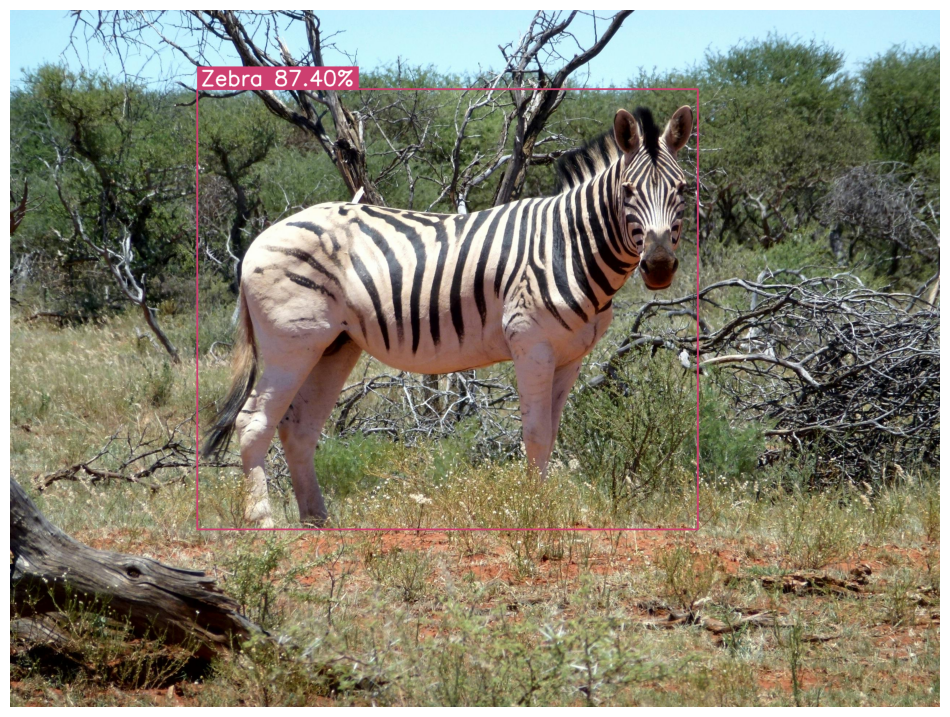

In [86]:
display_prediction("DATA/IMAGES/test_images/zebra_1.jpg",
                    save_fig=True, filename='zebras_detected_1.jpg'
                    )


0: 640x448 1 Giraffe, 5 Zebras, 990.0ms
Speed: 14.0ms preprocess, 990.0ms inference, 31.4ms postprocess per image at shape (1, 3, 640, 448)


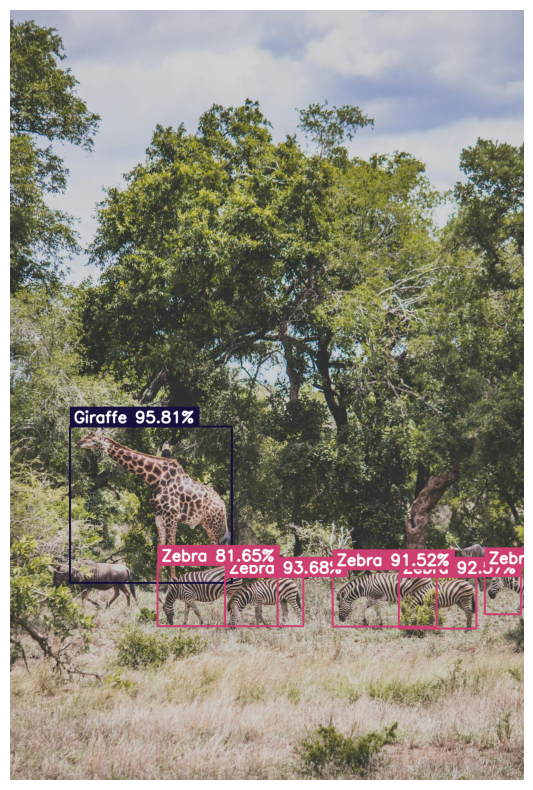

In [87]:
display_prediction("DATA/IMAGES/test_images/zebra_2.jpg")


0: 416x640 6 Elephants, 644.4ms
Speed: 5.0ms preprocess, 644.4ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


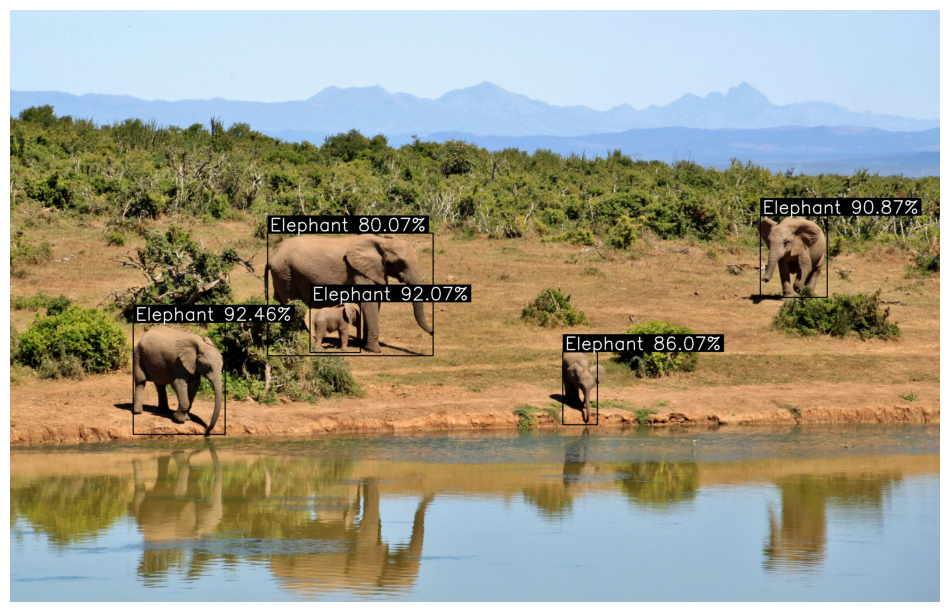

In [88]:
display_prediction("DATA/IMAGES/test_images/elephants.jpg")

## 5. Video Detection

Implementation for detecting and tracking animals in videos:

In [89]:
def predict_in_videos(video_path, save_video=False, filename=None):
    """
    Function to make predictions on video frames using a trained YOLO model and display the video with annotations.
    
    Parameters:
        video_path (str): Path to the video file.
        save_video (bool): If True, saves the video with annotations. Default is False.
        filename (str): The name of the output file where the video will be saved if save_video is True.
    """
    try:
        # Load video info and extract width, height, and frames per second (fps)
        video_info = sv.VideoInfo.from_video_path(video_path=video_path)
        w, h, fps = int(video_info.width), int(video_info.height), int(video_info.fps)

        # Calculate the optimal thickness for annotations and text scale based on video resolution
        thickness = sv.calculate_optimal_line_thickness(resolution_wh=video_info.resolution_wh)
        text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)

        # Initialize YOLO model, tracker, and color lookup for annotations
        box_annotator = sv.BoxAnnotator(thickness=thickness, color_lookup=sv.ColorLookup.TRACK)
        label_annotator = sv.LabelAnnotator(text_scale=text_scale, text_thickness=thickness, 
                                            text_position=sv.Position.TOP_LEFT,
                                            color_lookup=sv.ColorLookup.TRACK)
        
        model = YOLO("runs/detect/train/weights/best.pt")  # Load your custom-trained YOLO model
        tracker = sv.ByteTrack(frame_rate=fps)  # Initialize the tracker with the video's frame rate
        class_dict = model.names  # Get the class labels from the model

        # Directory to save the video with annotations, if required
        save_dir = "DATA/VIDEOS/captured_videos"
        if save_video and filename:
            os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists
            save_path = os.path.join(save_dir, filename)
            out = cv.VideoWriter(save_path, cv.VideoWriter_fourcc(*"XVID"), fps, (w, h))  # Initialize video writer

        # Capture the video from the given path
        cap = cv.VideoCapture(video_path)
        if not cap.isOpened():
            raise Exception("Error: couldn't open the video!")

        # Process the video frame by frame
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:  # End of the video
                break

            # Make predictions on the current frame using the YOLO model
            result = model(frame)[0]
            detections = sv.Detections.from_ultralytics(result)  # Convert model output to Detections format
            detections = tracker.update_with_detections(detections=detections)  # Track detected objects

            # Filter detections based on confidence
            if detections.tracker_id is not None:
                detections = detections[(detections.confidence > 0.5)]  # Keep detections with confidence > 0.5

                # Generate labels for tracked objects
                labels_0 = [f"#{trk_id} {class_dict[cls_id]} {conf*100:.2f}%" 
                            for trk_id, cls_id, conf in zip(
                            detections.tracker_id, detections.class_id, detections.confidence
                            )]
                labels_1 = [f"{class_dict[cls_id]} {conf*100:.2f}%" for cls_id, conf in zip(
                            detections.class_id, detections.confidence)]

                # Annotate the frame with bounding boxes and labels
                box_annotator.annotate(frame, detections=detections)
                label_annotator.annotate(frame, detections=detections, labels=labels_1)

            # Save the annotated frame to the output video file if save_video is True
            if save_video and filename:
                out.write(frame)

            # Display the video frame with annotations
            cv.imshow("Video", frame)

            # Break loop if 'p' key is pressed
            if cv.waitKey(1) & 0xff == ord('p'):
                break

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # Release resources
        cap.release()
        if save_video and filename:
            out.release()
        cv.destroyAllWindows()
        print("Video processing complete, resources released.")


In [ ]:
predict_in_videos(
    "DATA/VIDEOS/test_videos/zebras.mp4",
    save_video=True,
    filename='zebras_detected.mp4'
)


## Additional Notes

- The model uses YOLOv8 large (`yolov8l.pt`) as the base model for transfer learning
- The model is only trained for 6 classes: (`Elephant`, `Giraffe`, `Gorilla`, `Lion`, `Tiger`, `Zebra`)
- Detection confidence threshold is set to 0.5 for both image and video detection
- Video processing can be stopped by pressing the 'p' key
- The system supports both local files and URLs for image detection
- Detected images and videos are saved in their respective directories under `DATA/`
- You can find the project on Roboflow by clicking [here](https://universe.roboflow.com/puspendu-ai-vision-workspace/wild-animals-detection-fspct)

## Requirements
- ultralytics
- roboflow
- supervision
- opencv-python
- matplotlib
- numpy
- requests